# Initialize simulator

In [48]:
import numpy as np
from backend.simulation_tools import Simulator
from tasks import flip_flop
import matplotlib.pyplot as plt
%matplotlib inline

params = flip_flop.set_params(N_batch= 64, N_rec=10,
                       input_wait=5, stim_dur=2, quiet_gap=200, N_turns=2,
                       rec_noise=0, stim_noise=0.01,
                       dale_ratio=.8, tau=50, dt=10.)

x,y,mask = flip_flop.build_train_batch(params)

sim = Simulator(params, weights_path="./tasks/weights/flipflop.npz")



# Choose a trial

In [49]:
trial = x[3]
target = y[3]

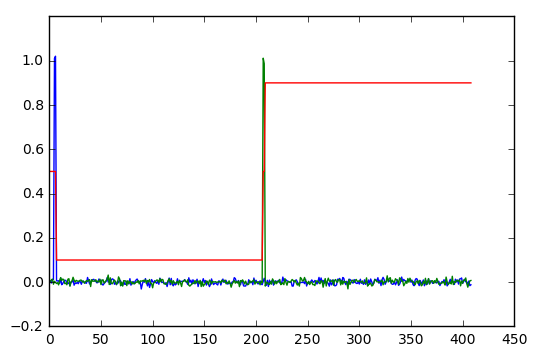

In [50]:
plt.plot(range(x.shape[1]), trial[:,0], range(x.shape[1]), trial[:,1], range(x.shape[1]), target)
plt.ylim([-.2, 1.2])
plt.show()


# Add selective time masking, run the trial

In [51]:
t_connectivity = []

for i in range(x.shape[1]):
    if 4 <= i and i <= 3 or 34 <= i and i <= 33:
        t_connectivity.append(np.zeros_like(sim.W_rec))
    else:
        t_connectivity.append(np.ones_like(sim.W_rec))

In [52]:
outputs, states = sim.run_trial(trial, t_connectivity)


# Plot output of network

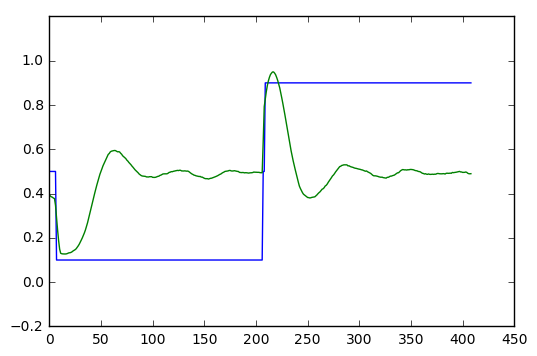

In [53]:
plt.plot(range(x.shape[1]), target, range(x.shape[1]), outputs[:,0])
plt.ylim([-.2, 1.2])
plt.show()

# Plot states over time, without and with RELU

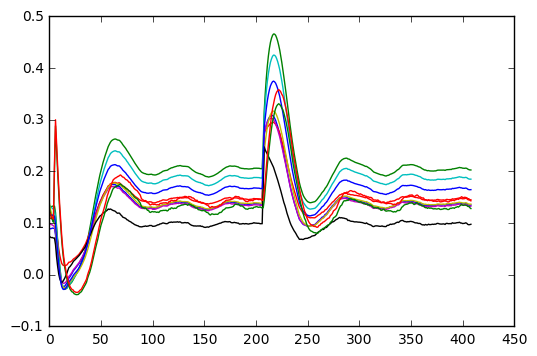

In [54]:
for i in range(states.shape[2]):
    plt.plot(range(states.shape[0]), states[:,0,i])
plt.show()

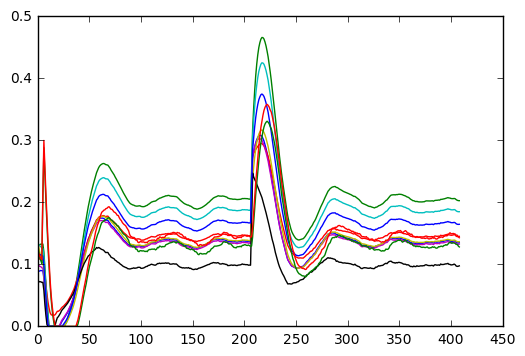

In [55]:
for i in range(states.shape[2]):
    plt.plot(range(states.shape[0]), np.maximum(states[:,0,i], np.zeros_like(states[:,0,i])))
plt.show()

# Plot W_rec and then animate effective W_rec given state and RELU

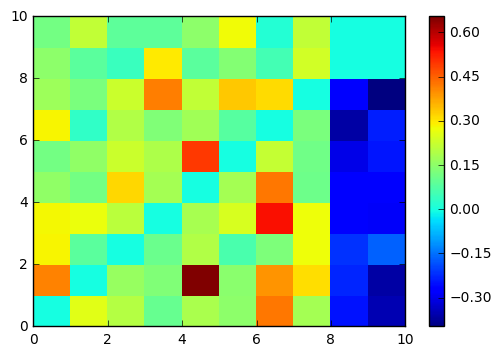

In [56]:
plt.pcolor(sim.W_rec)
plt.colorbar()
plt.show()

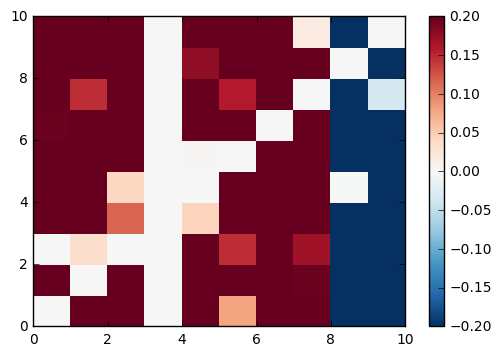

In [47]:
import matplotlib.animation as animation 
from IPython.display import HTML
from matplotlib import rc

fig = plt.figure()
    
ims = []


for i in range(states.shape[0]):
    Wi = np.matmul(np.absolute(sim.W_rec),sim.dale_rec) * t_connectivity[i]
    for j in range(sim.W_rec.shape[0]):
        if states[i, 0, j] < 0:
            Wi[:, j] = 0
    ims.append((plt.pcolor(Wi, vmin = -.2, vmax = .2, cmap='RdBu_r'),))

plt.colorbar()
rc('animation', html='html5')


animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000,
                                   blit=True)

# Effective input and output matrices

In [11]:
np.absolute(sim.W_in)

array([[  3.86803149e-05,   1.12083502e-01],
       [  8.41000001e-05,   6.21606857e-02],
       [  4.21542791e-05,   3.51774305e-01],
       [  1.18335040e-04,   2.13449672e-01],
       [  1.11016561e-04,   4.58592057e-01],
       [  1.45959959e-04,   3.16917300e-01],
       [  3.43197426e-05,   1.74585432e-02],
       [  8.07793404e-05,   2.50736505e-01],
       [  8.84987950e-01,   5.72674675e-04],
       [  5.28042018e-01,   8.83792964e-05]], dtype=float32)

In [12]:
np.matmul(np.absolute(sim.W_out),sim.dale_out)

array([[ 0.35083175,  0.40208551,  0.19569881,  0.46429184,  0.24487685,
         0.27118644,  0.43002728,  0.31496245,  0.        ,  0.        ]])

# "Black Box" paper analysis

In [57]:
def q(x):
    f = (1.0 / np.array(sim.tau)) * (-x + np.matmul(np.maximum(x, np.zeros_like(x)),
                                np.transpose(np.matmul(np.absolute(sim.W_rec),sim.dale_rec))))
    q = .5 * np.sum(np.square(f))
    return q

#+ np.matmul(rnn_in, np.transpose(np.absolute(sim.W_in))))
               
def dFidxj(x, i, j):
    if x[j] > 0:
        d = - 1.0 / sim.tau + (1.0 / sim.tau) * np.matmul(np.absolute(sim.W_rec),sim.dale_rec)[i][j]
    else:
        d = -1.0 / sim.tau
    return d
    
def grad_q(x):
    g = np.zeros_like(x)
    for j in range(len(x)):
        for i in range(len(x)):
            f = (1.0 / np.array(sim.tau)) * (-x + np.matmul(np.maximum(x, np.zeros_like(x)),
                                np.transpose(np.matmul(np.absolute(sim.W_rec),sim.dale_rec))))
            g[j] += dFidxj(x,i,j) * f[i]
    return g
        
                           
def hess_q(x):
    h = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            for k in range(len(x)):
                h[i,j] += dFidxj(x,k,i) * dFidxj(x,k,j)
    return h

In [58]:
from scipy.optimize import minimize

def opt(init):
    res = minimize(q, init, method = 'Newton-CG', jac = grad_q, hess = hess_q,
               tol = 1e-10, options = {'disp':True})
    
    if not res.success:
        print "FAILED TO CONVERGE"
    return res.x

### optimize q given some state as initial condition

In [59]:
trial = x[3]
outputs, states = sim.run_trial(trial)

In [60]:
test = opt(states[375,0,:])

         Current function value: 0.000001
         Iterations: 0
         Function evaluations: 21
         Gradient evaluations: 9
         Hessian evaluations: 1
FAILED TO CONVERGE


In [61]:
test

array([ 0.13551271,  0.20192898,  0.14552285,  0.18441833,  0.13338392,
        0.13652707,  0.09921628,  0.16458243,  0.12713121,  0.14183614])

### linear stability by taking eigenvalues of jacobian

In [62]:
def eig_dF(x):
    J = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            J[i,j] = dFidxj(x,i,j)
    return np.linalg.eigvals(J)

In [63]:
eig_dF(test)

array([-0.17870159+0.j        ,  0.00771879+0.j        ,
       -0.01056256+0.j        , -0.00261296+0.00460101j,
       -0.00261296-0.00460101j, -0.00576011+0.00117758j,
       -0.00576011-0.00117758j, -0.00065361+0.00168338j,
       -0.00065361-0.00168338j, -0.00040127+0.j        ])

### visualization of network with zero input, from initial conditions

In [70]:

tester = Simulator(params, weights_path="./tasks/weights/flipflop.npz")
tester.init_state = (states[400,0,:])

zero_trial = .1 * np.zeros_like(trial)

outputs, states = sim.run_trial(zero_trial, use_input=False)

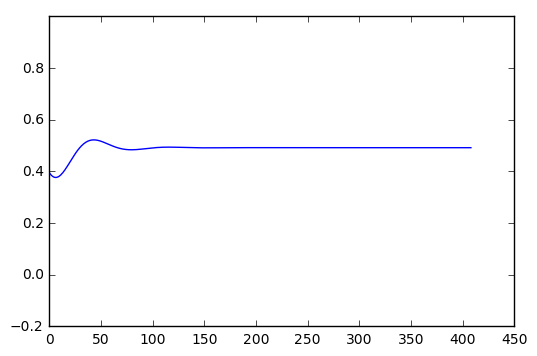

In [71]:
plt.plot(range(x.shape[1]), outputs[:,0])
plt.ylim([-.2, 1])
plt.show()

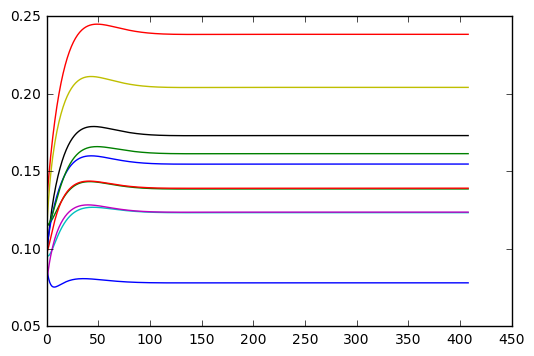

In [286]:
for i in range(states.shape[2]):
    plt.plot(range(states.shape[0]), states[:,0,i])
plt.show()

In [287]:
states[40]

array([[ 0.08076096,  0.14340211,  0.1437528 ,  0.12672167,  0.1284159 ,
         0.21113014,  0.17864681,  0.15997086,  0.16525014,  0.24387161]])

In [273]:
out_state = states[40,0]